## Ensemble modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [3]:
#Using the same datsasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [4]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

### Voting Regressor
Here, we will combine the predictions of different models. The function `VotingRegressor()` averages the predictions of all the models. 

Below are the individual models tuned in the previous chapters.

In [8]:
# Tuned XGBoost model 
m1 = xgb.XGBRegressor(random_state=1,max_depth=6,n_estimators=1000,gamma=1,
                                         learning_rate = 0.01,reg_lambda=0.001).fit(X, y)
print("RMSE for XGBoost = ", np.sqrt(mean_squared_error(m1.predict(Xtest), ytest)))


m2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),n_estimators=50,learning_rate=1.0,
                         random_state=1).fit(X, y)
print("RMSE for AdaBoost = ", np.sqrt(mean_squared_error(m2.predict(Xtest), ytest)))


m3 = RandomForestRegressor(n_estimators=300, random_state=1,
                        n_jobs=-1, max_features=2).fit(X, y)
print("RMSE for Random forest = ", np.sqrt(mean_squared_error(m3.predict(Xtest), ytest)))


m4 = GradientBoostingRegressor(max_depth=8,n_estimators=100,learning_rate=0.1,
                         random_state=1,loss='huber').fit(X, y)
print("RMSE for Gradient Boosting = ", np.sqrt(mean_squared_error(m4.predict(Xtest), ytest)))

RMSE for XGBoost =  5533.09714940882
RMSE for AdaBoost =  5693.165811600585
RMSE for Random forest =  5642.45839697972
RMSE for Gradient Boosting =  5405.787029062213


In [6]:
# Combining models that have been tuned individually
m1 = xgb.XGBRegressor(random_state=1,max_depth=6,n_estimators=1000,gamma=1,
                                         learning_rate = 0.01,reg_lambda=0.001)
m2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),n_estimators=50,learning_rate=1.0,
                         random_state=1)
m3 = RandomForestRegressor(n_estimators=300, random_state=1,
                        n_jobs=-1, max_features=2)
m4 = GradientBoostingRegressor(max_depth=8,n_estimators=100,learning_rate=0.1,
                         random_state=1,loss='huber')
en=VotingRegressor(estimators = [('xgb',m1),('ada',m2),('rf',m3),('gb',m4)])
en.fit(X,y)
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(en.predict(Xtest),ytest)))

Ensemble model RMSE =  5356.19553079535


### Stacking Regressor
Stacking is a more sophisticated method of ensembling models. The method is as follows:

1. The training data is split into *K* folds. Each of the *K* folds serves as a test data in one of the *K* iterations, and the rest of the folds serve as train data. 

2. Each model is used to make predictions on each of the *K* folds, after being trainined on the remaining *K-1* folds. In this manner, each model predicts the response on each train data point - when that train data point was not used to train the model.

3. Predictions at each training data points are generated by each model in step 2 (the above step). These predictions are now used as predictors to train a meta-model (referred by the argument *final_estimator*), with the original response as the response. The meta-model (or *final_estimator*) learns to combine predictions of differnt models to make a better prediction.

In [8]:
#Stacking using LinearRegression as the meta-model
en=StackingRegressor(estimators = [('xgb',m1),('ada',m2),('rf',m3),('gb',m4)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en.fit(X,y)
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(en.predict(Xtest),ytest)))

Ensemble model RMSE =  5311.051612697244


In [9]:
en.final_estimator_.coef_

array([0.1754083 , 0.28344251, 0.11715329, 0.44980934])

Note the above coefficients of the meta-model. The model gives the highest weight to the gradient boosing model, and the lowest weight to the random forest model. Also, note that the coefficients need not sum to one.

In [121]:
#Stacking using Lasso as the meta-model
en=StackingRegressor(estimators = [('xgb',m1),('ada',m2),('rf',m3),('gb',m4)],
                     final_estimator=LassoCV(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en.fit(X,y)
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(en.predict(Xtest),ytest)))

Ensemble model RMSE =  5310.481811320582


In [124]:
en.final_estimator_.coef_

array([0.17639973, 0.28186944, 0.1152561 , 0.45119952])

In [113]:
#Stacking using MARS as the meta-model
en=StackingRegressor(estimators = [('xgb',m1),('ada',m2),('rf',m3),('gb',m4)],
                     final_estimator=Earth(max_degree=1),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en.fit(X,y)
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(en.predict(Xtest),ytest)))

Ensemble model RMSE =  5303.308982301974


C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\akl0407\Anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [115]:
print(en.final_estimator_.summary())

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      59644        
h(x3-75435)     No      0.402779     
h(75435-x3)     No      -0.406517    
h(x1-74988)     No      0.822699     
h(74988-x1)     No      -0.119104    
h(x2-72702.8)   No      -0.449716    
h(72702.8-x2)   No      -0.280938    
x0              No      0.211986     
-------------------------------------
MSE: 25038308.7322, GCV: 25226136.6357, RSQ: 0.9070, GRSQ: 0.9063


# XGBoost for classification

In [14]:
data = pd.read_csv('Heart.csv')
data.dropna(inplace = True)
data.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [15]:
#Response variable
y = pd.get_dummies(data['AHD'])['Yes']

#Creating a dataframe for predictors with dummy varibles replacing the categorical variables
X = data.drop(columns = ['AHD','ChestPain','Thal'])
X = pd.concat([X,pd.get_dummies(data['ChestPain']),pd.get_dummies(data['Thal'])],axis=1)
X.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,asymptomatic,nonanginal,nontypical,typical,fixed,normal,reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,0,1,1,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,0,0,0,0,1,0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,0,0,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,1,0,0,0,1,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,0,1,0,0,1,0


In [16]:
#Creating train and test datasets
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,train_size = 0.5,random_state=1)

In [130]:
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                          DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',refit='accuracy')
# execute the grid search
grid_result = grid_search.fit(Xtrain, ytrain)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)

Best: 0.871494 using {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.01, 'n_estimators': 200}


In [131]:
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,2,3,4,5]
grid['subsample'] = [0.5,1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',refit='accuracy')
# execute the grid search
grid_result = grid_search.fit(Xtrain, ytrain)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)

Best: 0.871954 using {'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}


XGBoost has an additional parameter for classification: **scale_pos_weight**

Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.

The scale_pos_weight value is used to scale the gradient for the positive class.

This has the effect of scaling errors made by the model during training on the positive class and encourages the model to over-correct them. In turn, this can help the model achieve better performance when making predictions on the positive class. Pushed too far, it may result in the model overfitting the positive class at the cost of worse performance on the negative class or both classes.

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

Ref:https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20scale_pos_weight%20value%20is%20used,model%20to%20over%2Dcorrect%20them.

In [135]:
start_time = time.time()
param_grid = {'n_estimators':[25,100,500],
                'max_depth': [6,7,8],
              'learning_rate': [0.01,0.1,0.2],
               'gamma': [0.1,0.25,0.5],
               'reg_lambda':[0,0.01,0.001],
                'scale_pos_weight':[1.25,1.5,1.75]#Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(Xtrain,ytrain)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[22:00:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 25, 'reg_lambda': 0.01, 'scale_pos_weight': 1.5} 0.872183908045977


In [147]:
cv_results=pd.DataFrame(optimal_params.cv_results_)
cv_results.sort_values(by = 'mean_test_score',ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
409,0.111135,0.017064,0.005629,0.000737,0.25,0.2,6,25,0.01,1.5,"{'gamma': 0.25, 'learning_rate': 0.2, 'max_dep...",0.866667,0.766667,0.9,0.931034,0.896552,0.872184,0.05656,1
226,0.215781,0.007873,0.005534,0.001615,0.1,0.2,8,100,0,1.5,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2
290,1.391273,0.107808,0.007723,0.006286,0.25,0.01,7,500,0,1.75,"{'gamma': 0.25, 'learning_rate': 0.01, 'max_de...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2
266,1.247463,0.053597,0.006830,0.002728,0.25,0.01,6,500,0.01,1.75,"{'gamma': 0.25, 'learning_rate': 0.01, 'max_de...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2
269,1.394361,0.087307,0.005530,0.001718,0.25,0.01,6,500,0.001,1.75,"{'gamma': 0.25, 'learning_rate': 0.01, 'max_de...",0.833333,0.766667,0.9,0.931034,0.896552,0.865517,0.05874,2


In [22]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

In [134]:
model4 = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.01,max_depth=6,
                              n_estimators = 500,reg_lambda = 0.01,scale_pos_weight=1.75,use_label_encoder=False)
model4.fit(Xtrain,ytrain,eval_metric='error')
model4.score(Xtest,ytest)

0.7718120805369127

If we increase the value of *scale_pos_weight*, the model will focus on classifying positives more correctly. This will increase the recall (true positive rate) since the focus is on identifying all positives. However, this will lead to identifying positives aggresively, and observations 'similar' to observations of the positive class will also be predicted as positive resulting in an increase in false positives and a decrease in precision. See the trend below as we increase the value of *scale_pos_weight*.

## Precision & recall vs scale_pos_weight

>0 0.00 (0.00)
>1 0.77 (0.13)
>10 0.81 (0.09)
>100 0.85 (0.11)
>1000 0.85 (0.10)
>10000 0.90 (0.06)
>100000 0.90 (0.08)
>1000000 0.90 (0.06)
>10000000 0.91 (0.10)
>100000000 0.96 (0.03)
>1000000000 1.00 (0.00)


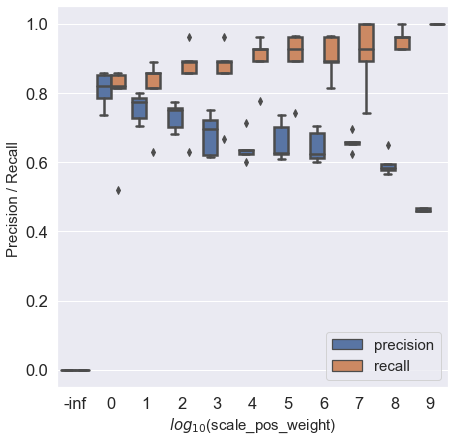

In [286]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.0f' % i
        models[key] = xgb.XGBClassifier(objective = 'binary:logistic',scale_pos_weight=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores_recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
    return list([scores_recall,scores_precision])

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results_recall, results_precision, names = list(), list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    scores_recall = scores[0]
    scores_precision = scores[1]
    # store the results
    results_recall.append(scores_recall)
    results_precision.append(scores_precision)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.2f (%.2f)' % (name, np.mean(scores_recall), np.std(scores_recall)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
sns.set(font_scale = 1.5)
pdata = pd.DataFrame(results_precision)
pdata.columns = list(['p1','p2','p3','p4','p5'])
pdata['metric'] = 'precision'
rdata = pd.DataFrame(results_recall)
rdata.columns = list(['p1','p2','p3','p4','p5'])
rdata['metric'] = 'recall'
pr_data = pd.concat([pdata,rdata])
pr_data.reset_index(drop=False,inplace= True)
#sns.boxplot(x="day", y="total_bill", hue="time",pr_data=tips, linewidth=2.5)
pr_data_melt=pr_data.melt(id_vars = ['index','metric'])
pr_data_melt['index']=pr_data_melt['index']-1
pr_data_melt['index'] = pr_data_melt['index'].astype('str')
pr_data_melt.replace(to_replace='-1',value =  '-inf',inplace=True)
sns.boxplot(x='index', y="value", hue="metric", data=pr_data_melt, linewidth=2.5)
plt.xlabel('$log_{10}$(scale_pos_weight)',fontsize=15)
plt.ylabel('Precision / Recall ',fontsize=15)
plt.legend(loc="lower right", frameon=True, fontsize=15)

In [193]:
#Adaboost 
model_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                               random_state=1,learning_rate=0.01).fit(Xtrain, ytrain)    
test_accuracy=model_ada.score(Xtest,ytest) #Returns the classification accuracy of the model on test data
    
#Random forest
model_rf = RandomForestClassifier(n_estimators=500, random_state=1,max_features=3,
                        n_jobs=-1,oob_score=False).fit(Xtrain, ytrain)
test_accuracy2=model_rf.score(Xtest,ytest) #Returns the classification accuracy of the model on test data
    
#Gradient boost
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=1,max_depth=4,learning_rate=1.0).fit(Xtrain, ytrain)
test_accuracy3=model_gb.score(Xtest,ytest) #Returns the classification accuracy of the model on test data

#XGBoost
model_xgb = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.01,max_depth=6,
                              n_estimators = 500,reg_lambda = 0.01,scale_pos_weight=1.75,
                           use_label_encoder=False).fit(Xtrain,ytrain)
test_accuracy4=model_xgb.score(Xtest,ytest) #Returns the classification accuracy of the model on test data

print("Adaboost accuracy = ",test_accuracy)
print("Random forest accuracy = ",test_accuracy2)
print("Gradient boost accuracy = ",test_accuracy3)
print("XGBoost model accuracy = ",test_accuracy4)

[22:52:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Adaboost accuracy =  0.7986577181208053
Random forest accuracy =  0.8120805369127517
Gradient boost accuracy =  0.7986577181208053
XGBoost model accuracy =  0.7718120805369127


## Ensemble modeling
### Voting classifier - hard voting
In this type of ensembling, the predicted class is the one predicted by the majority of the classifiers.

In [205]:
#Adaboost 
model_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                               random_state=1,learning_rate=0.01)   
    
#Random forest
model_rf = RandomForestClassifier(n_estimators=500, random_state=1,max_features=3,
                        n_jobs=-1,oob_score=False)
    
#Gradient boost
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=1,max_depth=4,learning_rate=1.0)

#XGBoost
model_xgb = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=0.25,learning_rate = 0.01,max_depth=6,
                              n_estimators = 500,reg_lambda = 0.01,scale_pos_weight=1.75,
                           use_label_encoder=False,eval_metric='error')

ensemble_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)])
ensemble_model.fit(Xtrain,ytrain)
np.mean(ensemble_model.predict(Xtest)==ytest)

0.8322147651006712

Note that the prediction accuracy of the ensemble is higher than the prediction accuracy of each of the individual models.

### Voting classifier - soft voting
In this type of ensembling, the predicted class is the one based on the average predicted probabilities of all the classifiers. The threshold probabiltiy is 0.5.

In [204]:
ensemble_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                 voting='soft')
ensemble_model.fit(Xtrain,ytrain)
np.mean(ensemble_model.predict(Xtest)==ytest)

0.7919463087248322

Note that soft voting will be good only for well calibrate classifiers, i.e., all the classifiers must have probabilities at the same scale.

### Stacking classifier
Conceptually, the idea is similar to that of Stacking regressor.

In [243]:
#Using Logistic regression as the meta model (final_estimator)
ensemble_model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=10000),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1))
ensemble_model.fit(Xtrain,ytrain)
np.mean(ensemble_model.predict(Xtest)==ytest)

0.7986577181208053

In [244]:
ensemble_model.final_estimator_.coef_

array([[0.8416763 , 1.35885574, 1.68328219, 1.38872517]])

In [239]:
#Using random forests as the meta model (final_estimator). Note that random forest will require tuning
ensemble_model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                   final_estimator=RandomForestClassifier(n_estimators=500, max_features=1,
                                                                          random_state=1,oob_score=True),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1))
ensemble_model.fit(Xtrain,ytrain)
np.mean(ensemble_model.predict(Xtest)==ytest)

0.825503355704698

Note that a complex *final_estimator* such as random forest will require tuning. In the above case, the *max_features* argument of random forests has been tuned to obtain the maximum OOB score.

In [240]:
#The final predictor - random forest obtains the maximum oob_score for max_features = 1
ensemble_model.final_estimator_.oob_score_

0.8581081081081081